In this part, we will focus on building a model for the predicate of sales in store 1 for product 1.
We will experiment with classical ML models for predicting series such as 
- NaiveSeasonal
- ARIMA
- AutoARIMA
- XGBModel
- Prophet
- ExponentialSmoothing

And evaluate their accuracy based on the **Mean Absolute Percentage Error (MAPE)** 

$$
\text{MAPE} = \frac{1}{n} \sum_{t=1}^{n} \left| \frac{A_t - F_t}{A_t} \right| \times 100
$$

Where:

* $A_t$ is the **actual** value at time $t$,
* $F_t$ is the **forecasted** value at time $t$,
* $n$ is the number of observations.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import darts
from darts import TimeSeries
from darts.metrics import mape

from darts.models import NaiveSeasonal, NaiveDrift
from darts.models import ARIMA
from darts.models import AutoARIMA
from darts.models import ExponentialSmoothing, AutoARIMA
from darts.models import XGBModel
from darts.models import Prophet
from darts.dataprocessing.transformers import Scaler

from statsmodels.tsa.stattools import adfuller

In [ ]:
def eval_forecast(model, val, forecast):
  """
  Evaluate the performance of a forecasting model using MAPE.

  Parameters:
  model (str):identifier of the forecasting model.
  val (TimeSeries or array-like): Actual validation data.
  forecast (TimeSeries or array-like): Forecasted data.

  Returns:
  float: MAPE score between actual and forecasted data.
  """

  mape_ = mape(val, forecast)
  print(f"model {model} obtains MAPE: {mape_:.2f}%")
  return mape_

def plot_actual_vs_forecast(actual, forecast, figsize=(20, 6)):
    """
    Plot the actual time series values against the forecasted values.

    Parameters:
    actual (TimeSeries or Series): Actual time series data.
    forecast (TimeSeries or Series): Forecasted time series data.
    figsize (tuple): Size of the plot figure (width, height).
    """

    plt.figure(figsize=figsize)
    actual.plot(label='Actual', c='grey')  # Plot actual values in grey
    forecast.plot(label='Forecast', c='red') # Plot forecasted values in red
    plt.legend()
    plt.title('Actual vs Forecast')
    plt.xlabel('Sales')
    plt.ylabel('Time')
    plt.grid()
    plt.show()

def enrich_with_date_features(df):
    """
    Add calendar-based time features to a DataFrame with a datetime index.

    Parameters:
    df (DataFrame): Time series DataFrame with a datetime index.

    Returns:
    DataFrame: The original DataFrame enriched with date-related features.
    """
    
    df = df.copy()
    df['day'] = df.index.day
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofweek'] = df.index.dayofweek
    df['dayofyear'] = df.index.dayofyear
    df['quarter'] = df.index.quarter
    df['weekofyear'] = df.index.isocalendar().week
    return df    

# Data preparation

In [ ]:
path ="data/"
df = pd.read_csv(path + 'train.csv.zip', compression='zip')
df['date'] = pd.to_datetime(df['date'])

print(f'Data column type: {df['date'].dtype}')
df = df.set_index('date')
df.iloc[:10]

Data column type: datetime64[ns]


,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10
2013-01-06,1,1,12
2013-01-07,1,1,10
2013-01-08,1,1,9
2013-01-09,1,1,12


Let's focus on one store and one product.  
  We will select a subset of the data that corresponds to the sales of the item with `item == 1` in the store with `store == 1`.


In [3]:
df_11 = df[(df['store'] == 1) & (df['item'] == 1)]  
print(df_11.item.value_counts(), df_11.store.value_counts())
df_11.head()

item
1    1826
Name: count, dtype: int64 store
1    1826
Name: count, dtype: int64


,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10


Divide the data into training and validation so that the validation starts from `2017-10-01` inclusive.

<Axes: xlabel='date'>

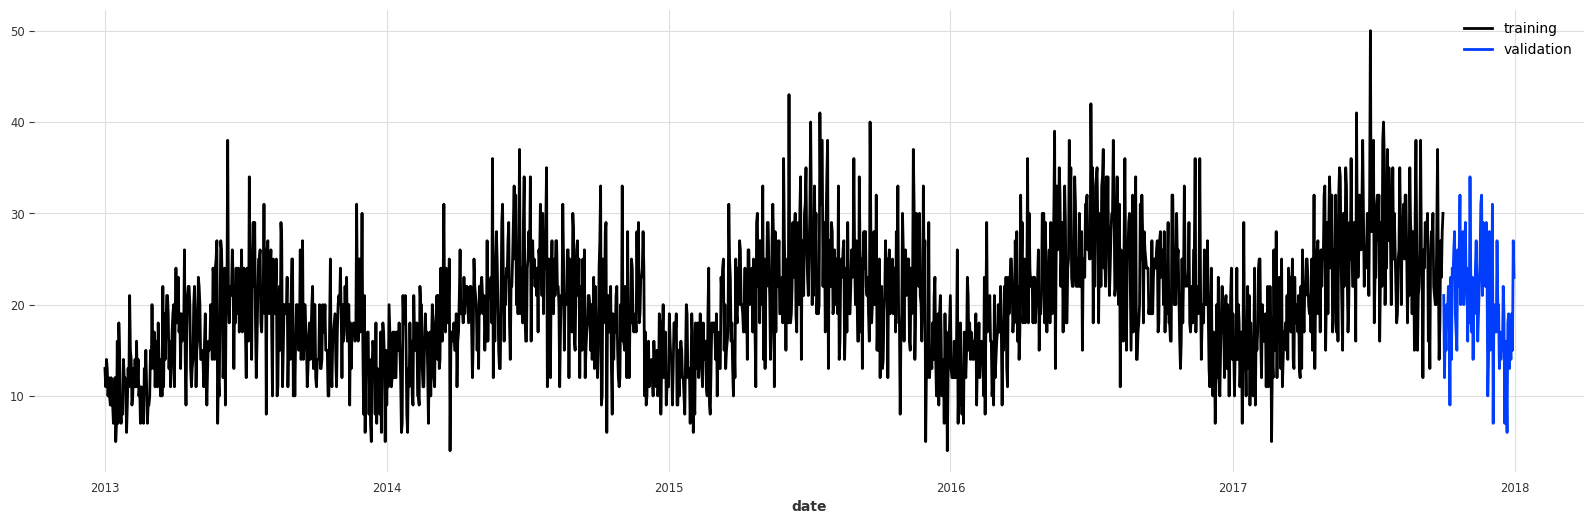

In [ ]:


series_darts = TimeSeries.from_dataframe(df_11, value_cols='sales')
series_darts

validation_split = '2017-10-01'
train, val = series_darts.split_before(pd.Timestamp(validation_split))

plt.figure(figsize=(20,6))
train.plot(label="training")
val.plot(label="validation")

# Train the models

Build a naive model for seasonal and trend prediction (NaiveSeasonal + NaieDrift) to predict data. 

Based on the preliminary data analysis, we will experiment with different prediction steps. We choose 7 and 365, because our data contains both local weekly trends and global annual trends.

<Axes: xlabel='date'>

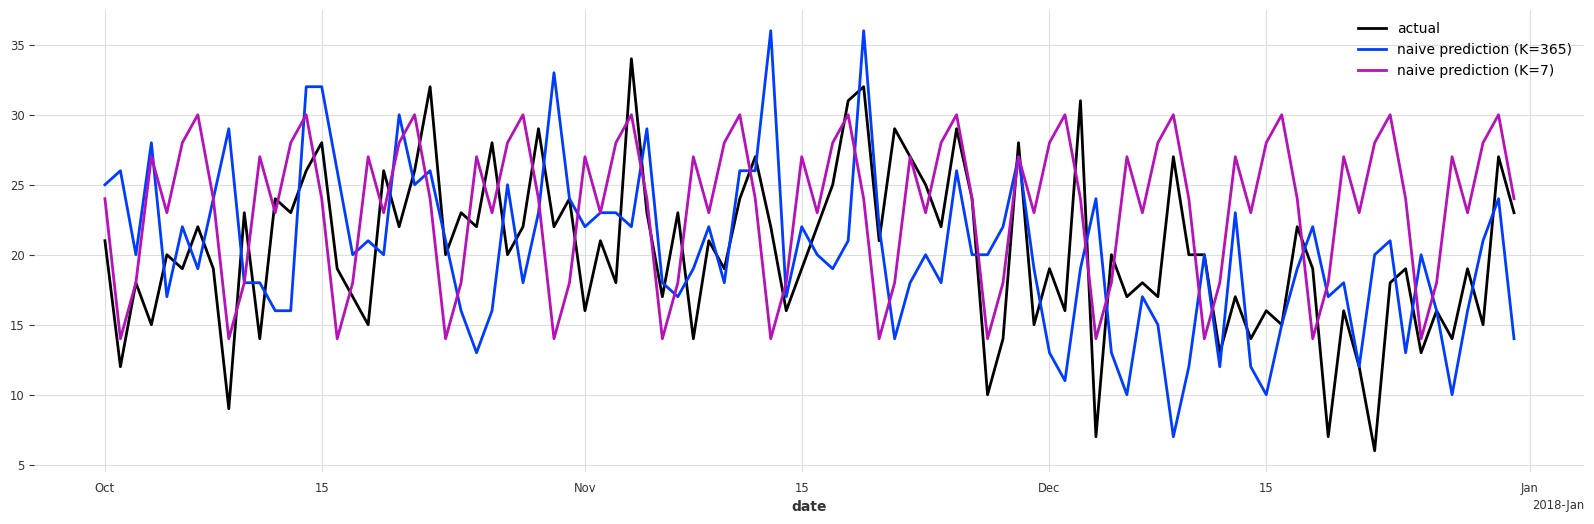

In [ ]:
# model Seasonal Naive with annual seasonality
naive_model_365 = NaiveSeasonal(K=365)
naive_model_365.fit(train)
seasonal_forecast_365 = naive_model_365.predict(len(val))

# model Seasonal Naive with weekly seasonality
naive_model_7 = NaiveSeasonal(K=7)
naive_model_7.fit(train)
seasonal_forecast_7 = naive_model_7.predict(len(val))

#plot the actual and forecasted values
plt.figure(figsize=(20,6))
val.plot(label="actual")
seasonal_forecast_365.plot(label="naive prediction (K=365)")
seasonal_forecast_7.plot(label="naive prediction (K=7)")


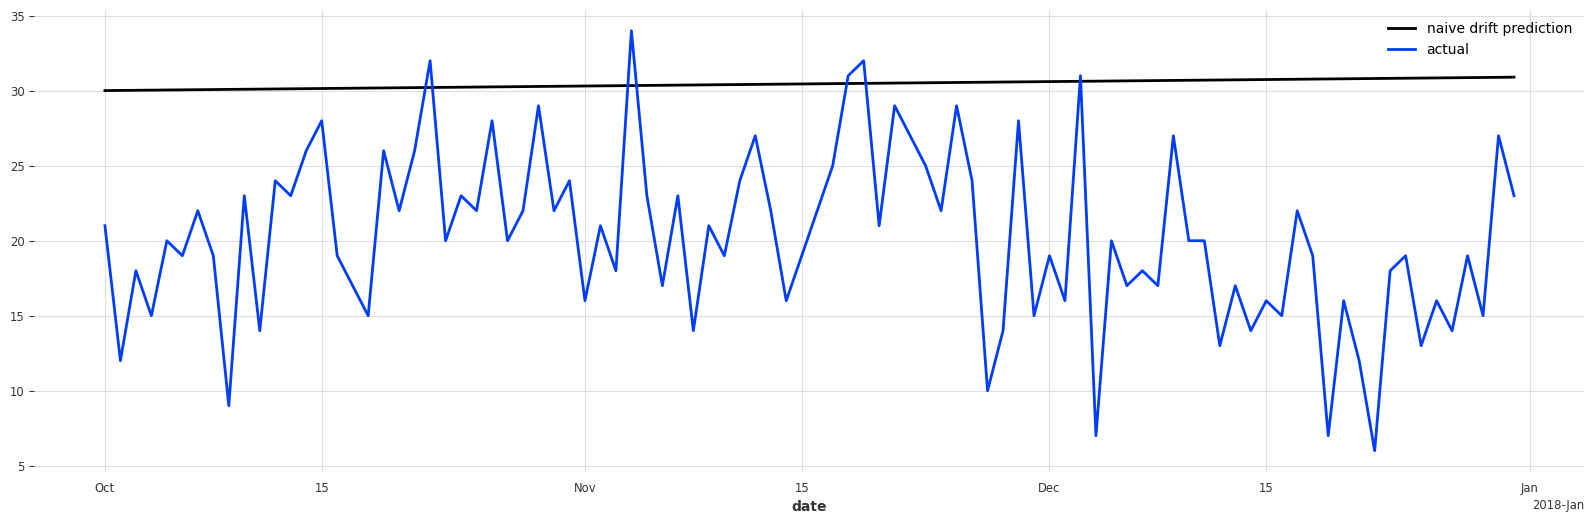

In [ ]:
# model Naive Drif
drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast = drift_model.predict(len(val))

plt.figure(figsize=(20,6))
drift_forecast.plot(label="naive drift prediction")
val.plot(label="actual")
plt.legend()

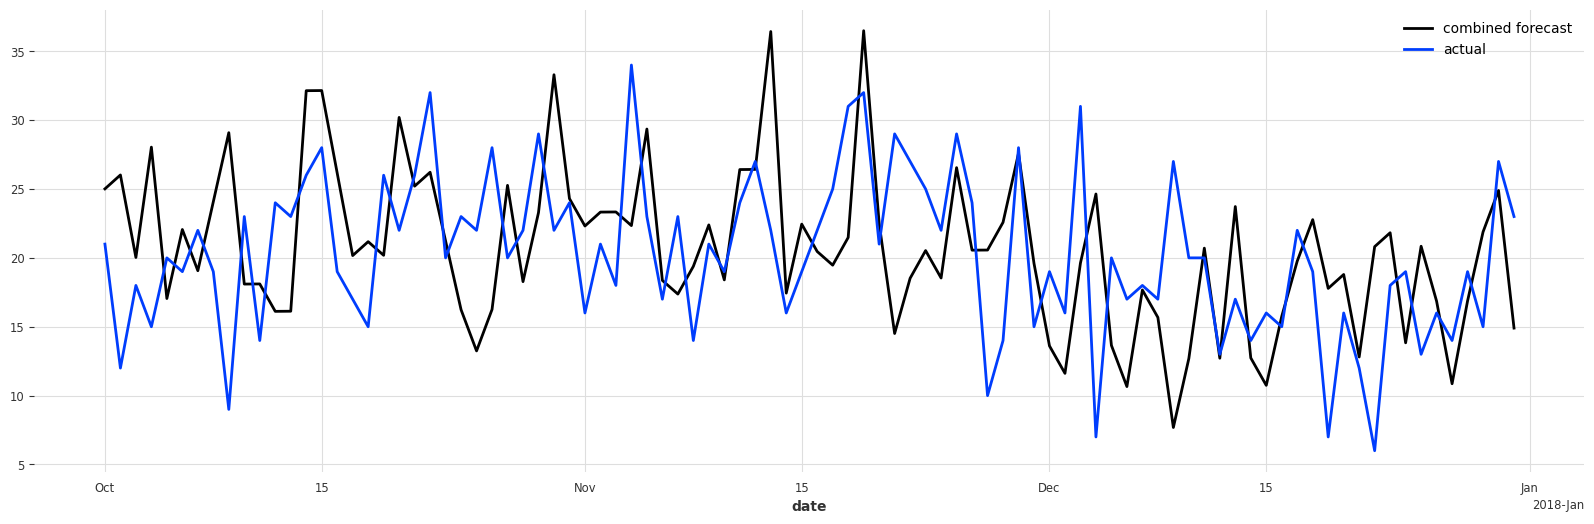

In [ ]:
# combine the seasonal and drift forecasts
combined_forecast = drift_forecast + seasonal_forecast_365 - train.last_value()
plt.figure(figsize=(20,6))
combined_forecast.plot(label="combined forecast")
val.plot(label="actual")
plt.legend()

<Axes: xlabel='date'>

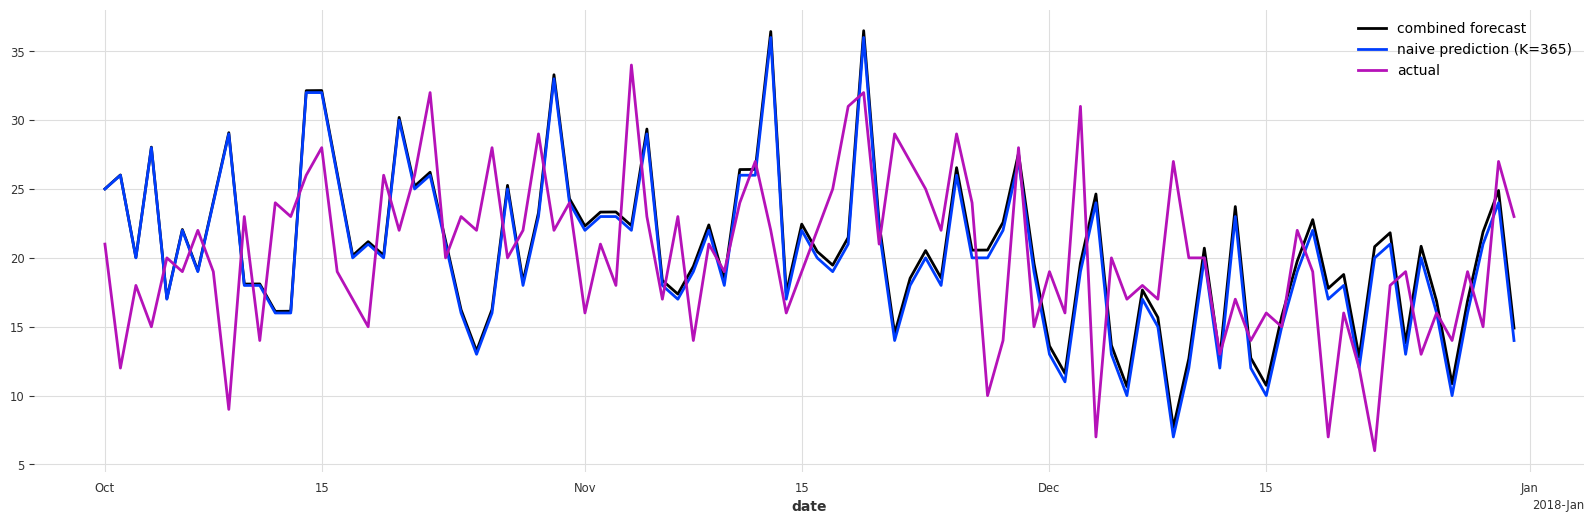

In [14]:
plt.figure(figsize=(20,6))
combined_forecast.plot(label="combined forecast")
seasonal_forecast_365.plot(label="naive prediction (K=365)")
val.plot(label="actual")

- We tried to test two hypotheses of seasonality: 7 days and 365 days. That is, weekly and equal seasonality.
- From the visualization, we can say that the annual seasonality showed a result closer to the truth.
- As an additional model, we tried to add Drift to Navoi Bayev, but visually they remained almost identical.

Now we can calculate the prediction error on validation with the naive model with MAPE.

In [16]:
mape_naive_365 = eval_forecast("naive_365", val, seasonal_forecast_365)
mape_naive_7 = eval_forecast("naive_7", val, seasonal_forecast_7)
mape_combined = eval_forecast("combined", val, combined_forecast)
mape_frift = eval_forecast("drift", val, drift_forecast)

model naive_365 obtains MAPE: 33.92%
model naive_7 obtains MAPE: 38.17%
model combined obtains MAPE: 34.26%
model drift obtains MAPE: 68.74%


- The 365-day naive model (MAPE: 33.92%) shows the lowest error among the naive models, suggesting that annual seasonality is a better parameter than short-term trends.
- The naive 7-day model (MAPE: 38.17%) shows the worst accuracy, which may indicate that long-term dependencies play a greater role than short-term ones
- The Combined model (MAPE: 34.26%) performs slightly worse than the Naïve model at 365 days. 
- Drift (MAPE: 68.74%) has the highest error, as it only takes into account the trend without seasonality.

Train the XBGModel with `darts` to predict our data. 

In [ ]:
# scaling the data with Scaler from darts
scaler = Scaler()
train_transformed = scaler.fit_transform(train)
test_transformed = scaler.transform(val)


model = XGBModel(
    lags = 365, #  Number of lags to include in the model
    output_chunk_length=1,  #  Forecasting 1 step ahead
    n_estimators=100,  # number of trees in the ensemble
    max_depth=3,  # max depth of each tree
    learning_rate=0.1,  # learning rate for the model
    subsample=0.8, 
    colsample_bytree=0.8  
)

# train the model
model.fit(train_transformed)
forecast_xgb = model.predict(len(val))

model XGB obtains MAPE: 25.81%


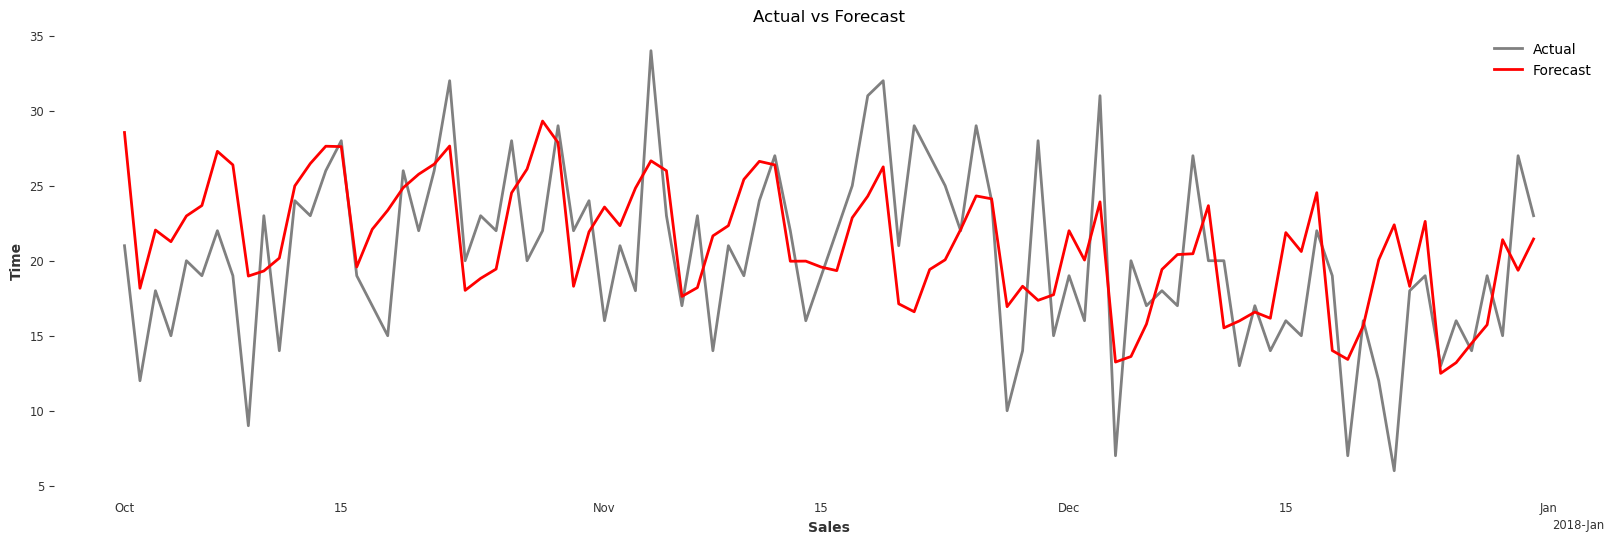

In [ ]:
# model evaluation
mape_xgb = eval_forecast("XGB", val, scaler.inverse_transform(forecast_xgb))
plot_actual_vs_forecast(val, scaler.inverse_transform(forecast_xgb))

Also add additional time features such as day, month, year, day of week, day of year, quarter, week of year

In [32]:
df_enriched = enrich_with_date_features(df_11)

date_covariates = TimeSeries.from_dataframe(
    df_enriched, value_cols=['day', 'month', 'year', 'dayofweek', 'dayofyear', 'quarter', 'weekofyear']
)

covariates_train, covariates_val = date_covariates.split_before(pd.Timestamp("2017-09-30"))



In [ ]:
model_enriched = XGBModel(
    lags = [-1,-7, -182, -365, -730], # set up the lags as a list to include multiple lags 
    lags_past_covariates=[-1], # include the last value of the covariates
    output_chunk_length=1, # forecasting 1 step ahead
    n_estimators=100,   # number of trees in the ensemble
    max_depth=3,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
)

# train the model with past covariates
model_enriched.fit(train, past_covariates=covariates_train)
forecast_xgb = model_enriched.predict(len(val), past_covariates=covariates_val)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


model XGB with future covariates obtains MAPE: 22.77%


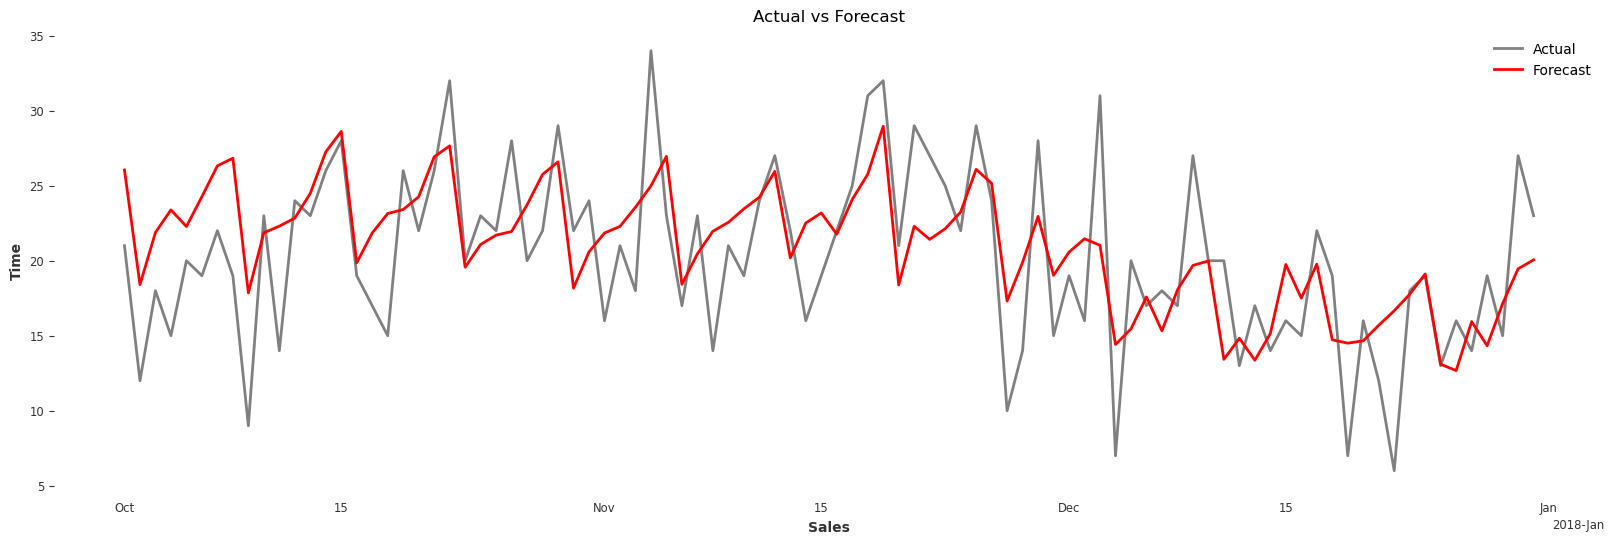

In [ ]:
#evaluate the model
mape_xgb_covariates = eval_forecast("XGB with future covariates", val, forecast_xgb) 
plot_actual_vs_forecast(val, forecast_xgb)

- XGB (MAPE: 25.81%) - even without additional temporal features, it demonstrates a good performance 
- XGB with covariates (MAPE: 22.77%) - while adding temporal characteristics (day, month, year, day of the week...) reduced the error by 3%. 
For the current task, this plays a very important role, and by directly adding calendar components, we are able to make better forecasts
- We also customized the model lags [-1, -7, -182, -365, -730]. Include weekly, six-month, annual, and two-year dependencies. This also significantly reduced the error rate.

Train the ExponentialSmoothing model and evaluate its performance.

In [ ]:
es = ExponentialSmoothing(seasonal_periods=365)
forecast_es = es.predict(len(val))

model ES obtains MAPE: 28.97%


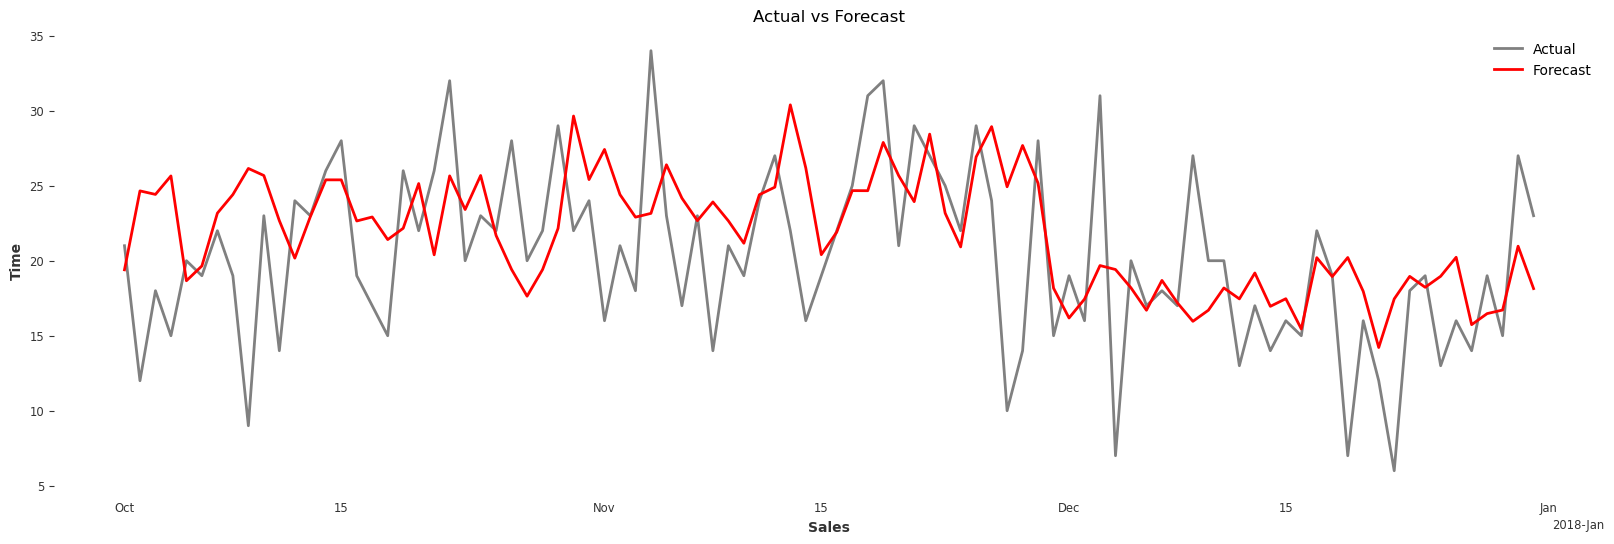

In [41]:
mape_es = eval_forecast("ES", val, forecast_es)
plot_actual_vs_forecast(val, forecast_es)

- ExponentialSmoothing (MAPE: 28.97%) is a good model. It is better than the Naive models but loses in accuracy to XGB 

Train the ARIMA model and define its parameters

In [ ]:
result = adfuller(df_11['sales'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -3.157671
p-value: 0.022569


- First, let's check the data for stationarity. According to the test results, the series is stationary at the 0.05 level of significance. Therefore, we do not need to differentiate it and the value of d will be 0.
- Based on the residual, we will set the first value for **p** using the PACF plot. We need to know the lag that is very close to the confidence interval for the first time. Let's try p = 8.
- We will determine **q** using the ACF, where it first approaches the confidence interval

In [ ]:
arima = ARIMA(p=8, d=0, q=52) 
arima.fit(train)
forecast_arima = arima.predict(len(val))

model ARIMA obtains MAPE: 31.13%


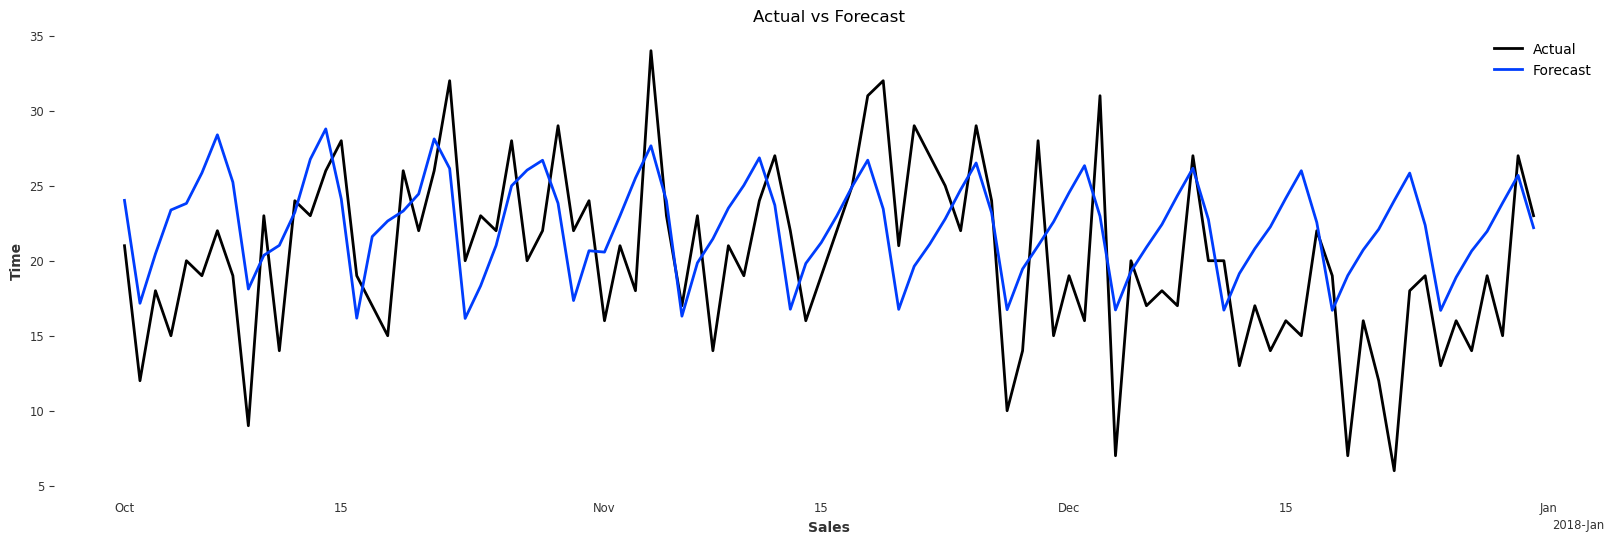

In [462]:
mape_arima = eval_forecast("ARIMA", val, forecast_arima)
plot_actual_vs_forecast(val, forecast_arima)

- As a result, ARIMA (MAPE: 31.13%) did not give the best result. The graph shows that the pattern is too monotonous and the model does not capture fluctuations in the data

 Let's try it Find the optimal parameters of the ARIMA model using AutoARIMA model. 

In [ ]:
autoarima = AutoARIMA(start_p=7, max_p=42, start_q=40, max_q=60, seasonal=True)
autoarima.fit(train)
forecast_autoarima = autoarima.predict(len(val))


model AutoARIMA obtains MAPE: 39.53%


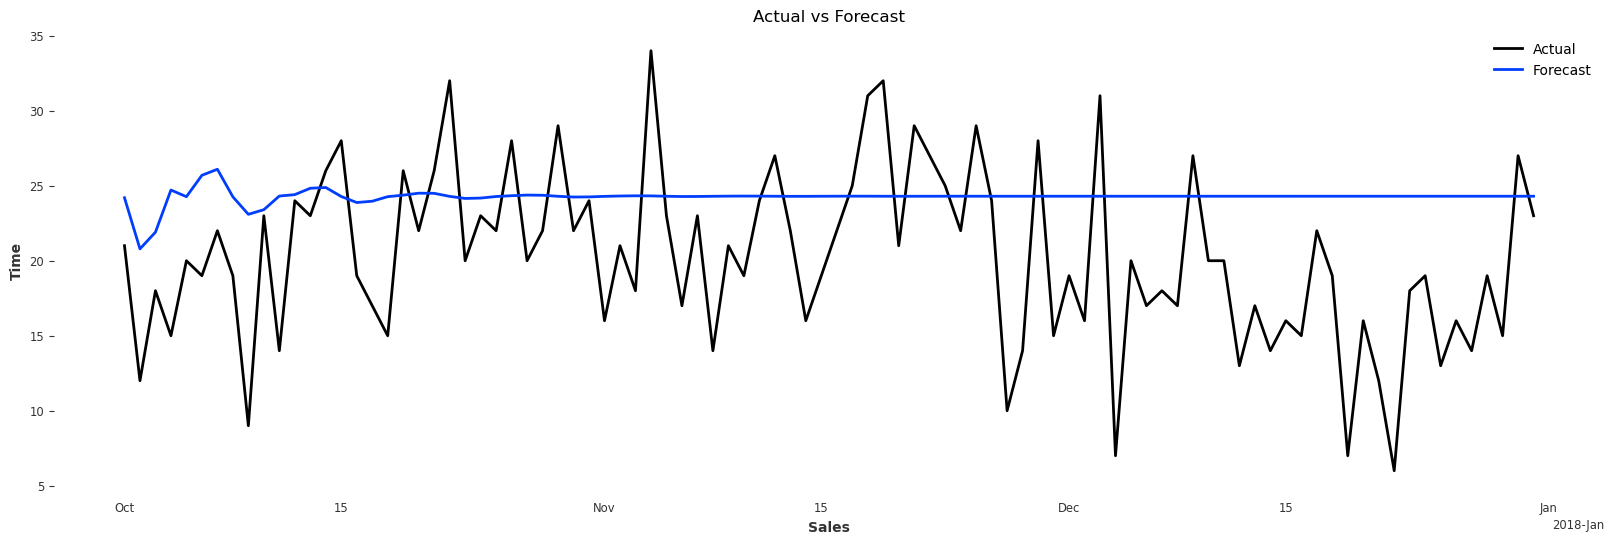

In [465]:
mape_autoarima = eval_forecast("AutoARIMA", val, forecast_autoarima)
plot_actual_vs_forecast(val, forecast_autoarima)

In [484]:
display(autoarima)

AutoARIMA(add_encoders=None, start_p=7, max_p=42, start_q=40, max_q=60, seasonal=True)

In [485]:
autoarima.model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1734
Model:               SARIMAX(7, 1, 1)   Log Likelihood               -5286.539
Date:                Mon, 03 Mar 2025   AIC                          10591.078
Time:                        10:08:05   BIC                          10640.196
Sample:                             0   HQIC                         10609.244
                               - 1734                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0346      0.038      0.904      0.366      -0.040       0.109
ar.L2         -0.0799      0.034     -2.379      0.017      -0.146      -0.014
ar.L3         -0.0775      0.033     -2.316      0.021      -0.143      -0.012
ar.L4         -0.0651      0.034     -1.939      0.053      -0.131       0.001
ar.L5         -0.0342      0.032     -1.063      0.288      -0.097       0.029
ar.L6          0.0062      0.030      0.207      0.836      -0.053       0.065
ar.L7          0.2638      0.029      9.042      0.000       0.207       0.321
ma.L1         -0.9071      0.026    -34.233      0.000      -0.959      -0.855
sigma2        26.0956      0.820     31.811      0.000      24.488      27.703
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                16.19
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.39   Skew:                             0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- Unfortunately, the model turned out to be worse and after 14 days it stopped predicting the data at all.
- As a result, we get the model Model:SARIMAX(p=7, d=1, q=1)

Train the Prophet model 

In [ ]:
prophet_model = Prophet(country_holidays='US' )
prophet_model.fit(train)
forecast_prophet = prophet_model.predict(len(val))

11:00:41 - cmdstanpy - INFO - Chain [1] start processing
11:00:41 - cmdstanpy - INFO - Chain [1] done processing


model Prophet obtains MAPE: 23.49%


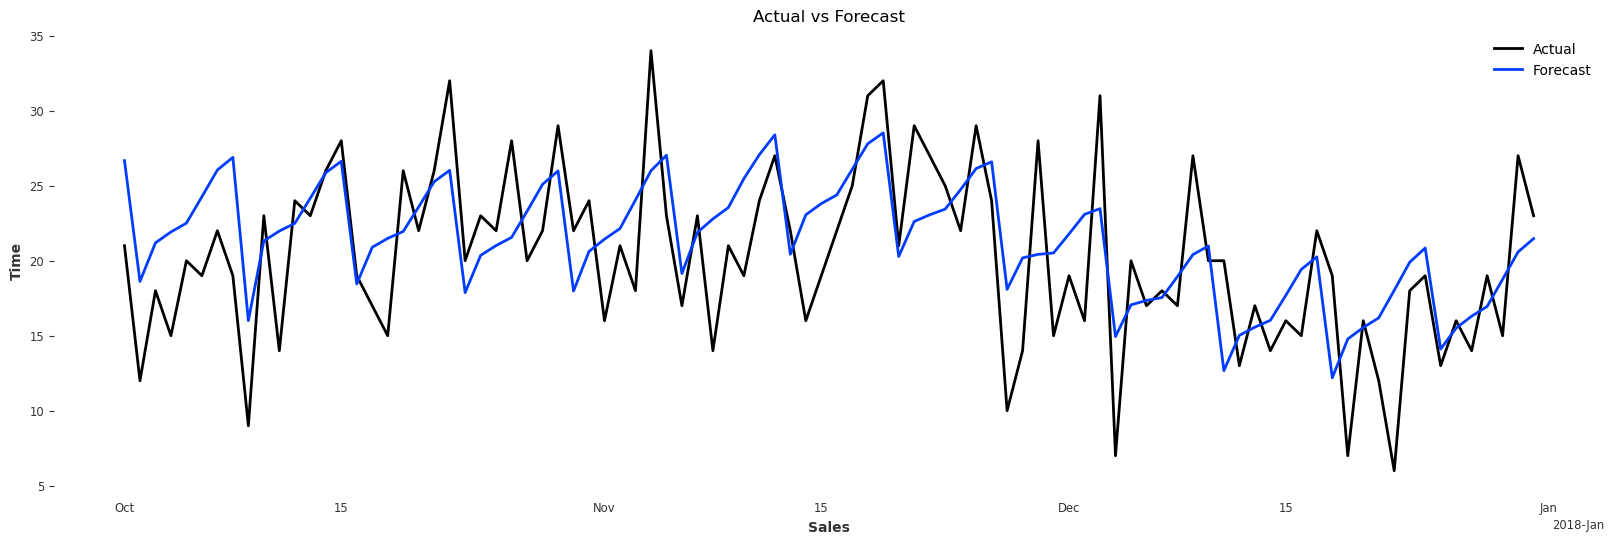

In [24]:
mape_prophet = eval_forecast("Prophet", val, forecast_prophet)
plot_actual_vs_forecast(val, forecast_prophet)

- The model showed a good result, especially when we additionally added holidays (country_holidays='US' )
- Prophet (MAPE: 23.49%) follows seasonality well (ups and downs), but the forecast pattern itself is monotonous 

# Back-testing
Finally, let's run a backtest for the model that turned out to be the best in our (XGB with covariates) study for a period of 1 year with 1 month (30 days) of predictions each time

| Model | MAPE |
|--------------------------------|-------|
| naive_365 | 33.92 |
| naive_7 | 38.17 |
| combined | 34.26 |
| drift | 68.74 |
| XGB | 25.81 |
| **XGB with covariates** | **22.77**|
| ExponentialSmoothing | 28.97 |
| ARIMA | 31.13 |
| AutoARIMA | 39.53 |
| Prophet | 23.49 |

In [ ]:
# model_enriched
df_enriched = enrich_with_date_features(df_11)

date_covariates = TimeSeries.from_dataframe(
    df_enriched, value_cols=['day', 'month', 'year', 'dayofweek', 'dayofyear', 'quarter', 'weekofyear']
)

covariates_train, covariates_val = date_covariates.split_before(pd.Timestamp("2017-09-30"))

# model with past covariates
model_enriched = XGBModel(
    lags = [-1,-7, -182, -365, -730],
    # lags_future_covariates=[-1], 
    lags_past_covariates=[-1],
    output_chunk_length=1,
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
)

model_enriched.fit(train, past_covariates=covariates_train)
forecast_xgb = model_enriched.predict(len(val), past_covariates=covariates_val)

_ = eval_forecast("XGB with future covariates", val, forecast_xgb)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


model XGB with future covariates obtains MAPE: 22.77%


In [26]:
df.index.min(), df.index.max()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2017-12-31 00:00:00'))

In [ ]:
hfc_params = {
    "series": series_darts,
    # "start": pd.Timestamp("2016-12-01"),
    "start": pd.Timestamp("2016-11-30"), 
    "forecast_horizon": 30,
    "verbose": True,
}

# backtest the model
historical_fcast = model_enriched.historical_forecasts(last_points_only=True, **hfc_params, past_covariates=date_covariates)

model Historical forecast obtains MAPE: 20.10%


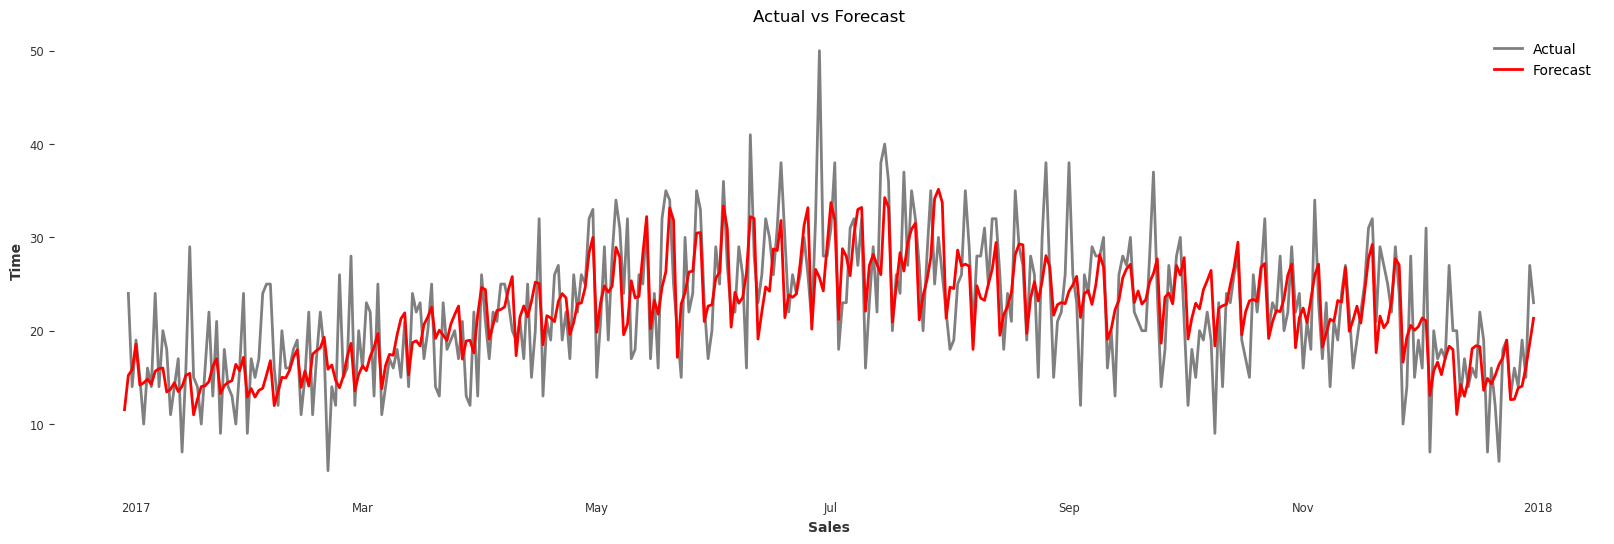

In [82]:
_, after = series_darts.split_before(pd.Timestamp("2016-12-30"))

mape_historical_fcast = eval_forecast("Historical forecast", after, historical_fcast)

plot_actual_vs_forecast(after, historical_fcast)

- According to the results, we see an improvement in accuracy (MAPE: 20.10%), but we still have significant peaks in the data that are very difficult to predict

Overall conclusion:
- When choosing a model, we should take into account seasonality and trend. Since our preliminary results showed good results on XGB, we would choose it
- Plans to improve the model.  We can build a separate model for each store and product (500 models). But it is better to group stores and products with similar characteristics to reduce the number of models. For stores, divide them into those with consistently higher sales for all products. And for products, divide them by how popular the product is (unpopular, average, popular) across all stores. it might look something like this (based on the heat map from task 2). As a result, we will have only (3*2) 6 models
    - High-selling (2, 3, 4, 8, 9, 10) and low-selling (1, 5, 6, 7)
    - Unpopular products: (1 3 4 5 16 17 23 27 34 40....), Medium: (2 6 7 9 14 19 20 21 26 30 31 32...) Popular: (8 10 13 15 18 22 25 28...)